## Test2Achieve - Autograding.ipynb

### Team 4: * Bharat Sharma * Adithya Vinod * Shanmukha Sai Penumatsa

### Course: DAAN 897 - Deep Learning (Spring I, 2023)

### Guide: Dr. Youkim Badr



**PROBLEM STATEMENT:** In the world where CHATGPT exist, we want to give some powers to faculty by automating the process of evaluation and answer generation.

Keywords:Descriptive Answer evaluation, Automatic Grading, Descriptive Examination System

We have tried to solve this problem by breaking it down into two independent problem statements, namely:

- Automated Answer Generation: We will be using pretrained models like Bert, Albert and Electra for answer generation tasks, where given a question or prompt, the model generates an answer. These models are trained on large amounts of text data and can learn to generate coherent and accurate response

- Automated Grading: The answer and scores are first passed through the LSTM which are then passed through the multiple neural layers to train the model. The trained model will return a score for each answer based on historic grading

In this python notebook we will be talking about the Automatic grading part of it

In [82]:
# importing all the necessary library
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [69]:
# for pre-processing
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
# We have downloaded the below files and hence commented it out for not downloading it again
# nltk.download('punkt')
# nltk.download('stopwords')
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Embedding

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

In [70]:
# To Utilize the computational resource (GPU) we have created a separate environment
# this environment consist tensorflow gpu version
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Collection:

We have used "The Hewlett Foundation: Automated Essay Scoring" dataset for building the neural network for answer grading

It contains information like the essay id, essay which is the answer for our case and their respective grades.

Each essay has in between 150-550 words in length

In [71]:
test_data = pd.read_csv("test_set.tsv",sep='\t', encoding='ISO-8859-1')
training_data = pd.read_csv("training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1',
                            usecols = ['essay_id', 'essay_set', 'essay','domain1_score'])
valid_data = pd.read_csv("valid_set.tsv",sep='\t', encoding='ISO-8859-1')

### Data Exploration:

We are exploring the data shape, rows and their first five values to get an idea of how the data looks like

In [72]:
training_data.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [73]:
test_data.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN


In [74]:
valid_data.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,NaN
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,NaN
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,NaN
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,NaN
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,NaN


### Data Preprocessing

- Dropping null values: Null values can be a issues so we have dropped the null values 
- Text Cleaning: Removing irrelevant information like punctuation, numbers, special charatecs and stop words from the text
- Toeknization: Breaking down the text into smaller chunks

We have created separate functions for performing all of this inside of the code, where function does the job in a abstract way

In [75]:
test_data.dropna(axis=1,inplace=True)
valid_data.dropna(axis=1,inplace=True)
training_data.dropna(axis=1,inplace=True)

- Splitting the dataset into X and y part

In [76]:
training_data
y = training_data['domain1_score']
X = training_data.copy()
X,y

(       essay_id  essay_set                                              essay  \
 0             1          1  Dear local newspaper, I think effects computer...   
 1             2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
 2             3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
 3             4          1  Dear Local Newspaper, @CAPS1 I have found that...   
 4             5          1  Dear @LOCATION1, I know having computers has a...   
 ...         ...        ...                                                ...   
 12971     21626          8   In most stories mothers and daughters are eit...   
 12972     21628          8   I never understood the meaning laughter is th...   
 12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
 12974     21630          8                                 Trippin' on fen...   
 12975     21633          8   Many people believe that laughter can improve...   
 
        domain

In [83]:
def wordlist_from_essay(essay_vector, remove_stopwords):
    # Tokenizing the words and removing if there are any lables
    essay_vector = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_vector.lower().split()
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        words = [word for word in words if not word in stop_words]
    return (words)

def sentences_from_essay(essay_vector, remove_stopwords):
    # function to tokenizing the sentences and calling the wordlist function
    obj_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = obj_tokenizer.tokenize(essay_vector.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(wordlist_from_essay(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    # Creating Feactur Vector from model
    feature_vector = np.zeros((num_features,),dtype="float32")
    word_count = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            word_count += 1
            feature_vector = np.add(feature_vector,model[word])        
    feature_vector = np.divide(feature_vector,word_count)
    return feature_vector

def getAvgFeatureVecs(essays, model, num_features):
    # Creating average of feature vector from model
    counter = 0
    essay_feature_vecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essay_feature_vecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essay_feature_vecs

def makeFeatureVec(words, model, num_features):
    feature_vector = np.zeros((num_features,),dtype="float32")
    word_count = 0.
    if isinstance(words, list):
        words = " ".join(words)
    for word in words.split():
        if word in model.wv:
            word_count = word_count + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if word_count > 0.:
        feature_vector = np.divide(feature_vector, word_count)
    return feature_vector


### Methodology:

- Preprocessing and cleaning: After downloading the data, the biggest part of it was to pre process it, where we have used two different techniques, We have tokenized the paragraphs to Sentence based toeknizer to preserve the context and further we have tokenized into a wordlist based tokenizer

- Vectorize: After the initial pre processing we created 3 separate functions for respective work
  - Function makeFeatureVec: Created an average feature vector for a given list of words, using ta trained word2vec model
  - Function getAvgFEatureVecs: Genereated a words vectors for a list of essays.
  - Function makeFeatureVec: Creates an average feature vectir for a given string of words
  
**Keywords:** Natural language processing, Descriptive Answer processing, Descriptive Answer Evaluation, LSTM, Deep Learning

- Model Selection: 

  - **LSTM (Long Short-Term Memory)** is a type of recurrent neural network (RNN) that is particularly effective in dealing with sequential data such as text. LSTM can capture the long-term dependencies and relationships between words in an essay, making it a suitable choice for grading written answers. It can also handle variable-length sequences, which is important for essays of different lengths.

  - **Word2Vec** is a neural network-based technique to generate word embeddings, which are vector representations of words in a high-dimensional space. Word2Vec model is used for the answer grading process as it helps to represent words in a dense vector space that captures the context and meaning of the words. This enables the model to understand the relationships between words and identify the similarity between different words. By using Word2Vec model, the answer grading process can take into account not only the words used in the answer but also their meaning and context, allowing for more accurate and robust grading.

- Model Specification: The model consists of two LSTM layers followed by a dropout layer and a dense layer with a single output node. For the metrics we have used MAR and accuracy and have created plots for checking the loss function and mae. For optimizer we have used RMSprop optimizer 

In [84]:
def get_model():
    """
    Defining the model architecture that will be used
    """
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', 'accuracy'])
    model.summary()
    return model

### Model Fitting and Validation

The code performs a 5-fold cross-validation on the given dataset using the KFold function from the scikit-learn library. For each fold, the code preprocesses the training and testing data, creates a Word2Vec model for the essays, generates average feature vectors for the essays using the model, reshapes the feature vectors, and trains an LSTM model using the feature vectors and corresponding labels.

After training, the code makes predictions on the testing set, rounds the predictions to the nearest integer, and evaluates the model using the quadratic weighted kappa metric. The resulting kappa score for each fold is printed and saved in a list of results. Finally, the average kappa score is calculated over the five folds, representing the overall performance of the model. Additionally, the weights of the last model in the 5-fold cross-validation are saved for future use.

In [85]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    sentences_test = []
    clean_train_essays = []
    clean_test_essays = []
    for essay in train_essays:
        sentences += sentences_from_essay(essay, remove_stopwords = True)
    for test_essay in test_essays:
        sentences_test += sentences_from_essay(test_essay, remove_stopwords = True)
    for essay_v in train_essays:
        clean_train_essays.append(wordlist_from_essay(essay_v, remove_stopwords=True))
    for test_essay in test_essays:
        clean_test_essays.append(wordlist_from_essay(test_essay, remove_stopwords=True))
            
    num_features = 300
    min_word_count = 40
    num_workers = 8
    context = 10
    downsampling = 1e-3

    model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(wordlist_from_essay( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model = get_model()
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=100, validation_data=(testDataVecs, y_test))
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
     
    # Save any one of the 5 models.
    if count == 5:
         lstm_model.save_weights('final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1


--------Fold 1--------

Training Word2Vec Model...
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 1, 300)            721200    
                                                                 
 lstm_133 (LSTM)             (None, 64)                93440     
                                                                 
 dropout_66 (Dropout)        (None, 64)                0         
                                                                 
 dense_66 (Dense)            (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
163/163 [==============================] - 8s 19ms/step - loss: 80.1743 - mae: 5.2767 - accuracy: 0.1185 - val_loss

In [89]:
cv = KFold(n_splits=5, shuffle=True)
results = []

count = 1
for train_idx, test_idx in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    train_essays = X_train['essay']
    test_essays = X_test['essay']

    sentences = []
    sentences_test = []
    clean_train_essays = []
    clean_test_essays = []
    for essay in train_essays:
        sentences += sentences_from_essay(essay, remove_stopwords=True)
    for test_essay in test_essays:
        sentences_test += sentences_from_essay(test_essay, remove_stopwords=True)
    for essay_v in train_essays:
        clean_train_essays.append(wordlist_from_essay(essay_v, remove_stopwords=True))
    for test_essay in test_essays:
        clean_test_essays.append(wordlist_from_essay(test_essay, remove_stopwords=True))

    num_features = 300
    min_word_count = 40
    num_workers = 8
    context = 10
    downsampling = 1e-3

    model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(wordlist_from_essay(essay_v, remove_stopwords=True))
    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represents one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    lstm_model = get_model()
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=100, validation_data=(testDataVecs, y_test))

    y_pred = lstm_model.predict(testDataVecs)

    # Save any one of the 5 models.
    if count == 5:
         lstm_model.save_weights('final_lstm.h5')

    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1



--------Fold 1--------

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_142 (LSTM)             (None, 1, 300)            721200    
                                                                 
 lstm_143 (LSTM)             (None, 64)                93440     
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
163/163 [==============================] - 7s 19ms/step - loss: 79.0831 - mae: 5.3330 - accuracy: 0.1175 - val_loss: 65.6250 - val_mae: 5.0033

###  Model Evaluation:

 - It seems that the model has a good performance, with an average Kappa score of 0.91. This means that the model has a high level of agreement with the human graders in assessing the quality of the essay answers. It also indicates that the model is able to generalize well to new data, as the cross-validation approach ensures that the model is tested on different subsets of the data. Overall, this is a promising result that suggests that the model can be used to grade essays in an automated and efficient way.

- We can also see that the training loss and the testing loss is following the same trend and it is going down each epochs but at the end of the curve it is flattening out which means the model woult not perform better even if we increase epochs

- We can also see that the mean absolute error and the testing mean absolute error and both is following the downwards trend and won't perform better even if we increase epochs

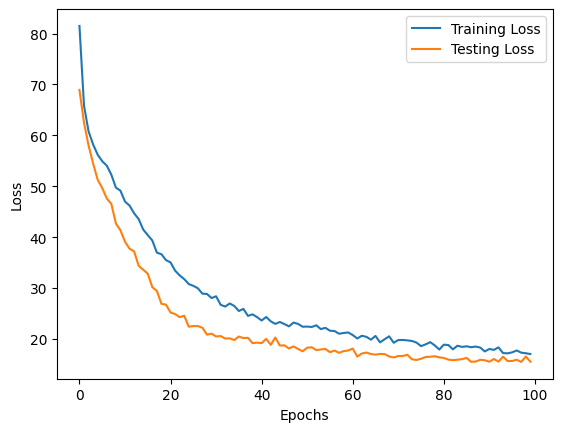

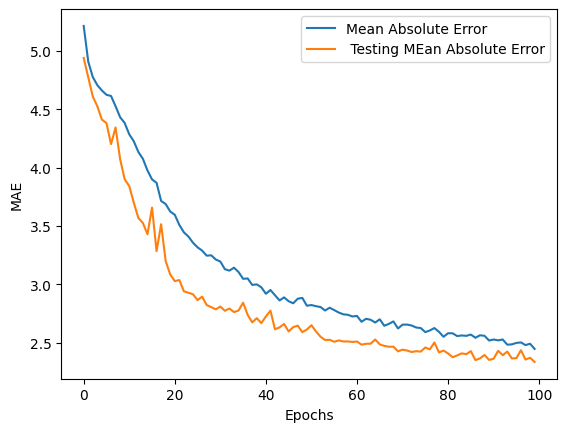

In [86]:
# Plot the training and testing loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plot the training and testing accuracy
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.plot(history.history['val_mae'], label=' Testing MEan Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()





In [88]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9109


In [63]:
training_data.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [67]:
X.tail()

,essay_id,essay_set,essay,domain1_score
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40
12975,21633,8,Many people believe that laughter can improve...,40


### Issues / Improvements

- We can used SBERT model for further adding context
- We can also create a taxonomy that can further add semantic context
- We can add semantic context match to furhter enhance model performance

### References:

Dataset 1 - https://rajpurkar.github.io/SQuAD-explorer/ <br>
Dataset 2 - https://www.kaggle.com/competitions/asap-sas/data  <br>
https://huggingface.co/docs/transformers/tasks/question_answering <br>
https://github.com/alexaapo/BERT-based-pretrained-model-using-SQuAD-2.0-dataset <br>
r-net.pdf (microsoft.com) 
Research Paper: https://ieeexplore.ieee.org/document/9002048 <br>
Research Paper2: https://ieeexplore.ieee.org/document/9316110 <br>


### Credits

**We have used the following dataset https://www.kaggle.com/competitions/asap-aes**
It is based on my extension of my research paper https://ieeexplore.ieee.org/document/9002048 which talks about the intial base algorithm we created. 
Based on the NLP and deep Learning We have extended below and added deep learning techniques learned through this course.